A notebook to look at the JDF boundary conditions with comparisons to WOD database and IOS data.

Observed data in this region is from 1976 to 2014.

In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
from salishsea_tools import viz_tools, tidetools, nc_tools
import numpy as np

import datetime
from salishsea_tools.nowcast import analyze
import comparisons
import ACTDR
import pandas as pd

%matplotlib inline

In [2]:
#make plots pretty
sns.set_style('darkgrid')
sns.set_color_codes()

#Load Model Grid

In [3]:
f=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy=f.variables['Bathymetry'][:]
X=f.variables['nav_lon'][:]
Y=f.variables['nav_lat'][:]

#Load WOD observations

In [4]:
data_WOD = comparisons.read_file_to_dataframe('/ocean/nsoontie/MEOPAR/WOD/CTDS7412')    

#Load more IOS and WOD data

In the region of interest, the above data set only covers up to 2009.

So, use Robbie's functions to load IOS and WOD data beyond 2009.

In [5]:
ACTDR.load_dat('JuandeFucaMouth.dat')

> open  JuandeFucaMouth.dat
> load CTD_DAT
> load STANDARD_KEYS
> close  JuandeFucaMouth.dat
> complete


In [6]:

data_IOS = pd.DataFrame(ACTDR.CTD_DAT)

data_IOS['Datetime'] = [datetime.datetime(y,m,d) for y,m,d in zip(data_IOS.Year,data_IOS.Month,data_IOS.Day)]
                        
data_IOS.drop('ID', axis=1, inplace=True)

to=datetime.datetime(2010,1,1)
tf=datetime.datetime(2015,12,31)

data_IOS = comparisons.isolate_time_period(data_IOS,to,tf)

## Combine both data sets

In [7]:
data=pd.concat([data_WOD,data_IOS],ignore_index=True)

data.tail()

,Datetime,Day,Depth,Latitude,Longitude,Month,Salinity,Temperature,Year
36634,2013-08-19,19,"[5.94929931573, 6.94083236645, 7.93236060748, ...",48.486333,-124.685167,8,"[31.4263, 31.4193, 31.444, 31.445, 31.4518, 31...","[10.814, 10.8557, 10.7226, 10.7152, 10.7035, 1...",2013
36635,2014-04-03,3,"[1.98313019088, 2.97468807061, 3.96624114006, ...",48.424833,-124.754833,4,"[26.3528, 26.3555, 26.3803, 26.5447, 26.7799, ...","[10.2492, 10.2493, 10.248, 10.2367, 10.205, 10...",2014
36636,2014-04-03,3,"[1.98311668101, 2.97466780585, 3.96621412045, ...",48.499167,-124.735000,4,"[25.8146, 25.8295, 26.0486, 26.168, 26.3534, 2...","[10.3173, 10.3164, 10.2964, 10.2828, 10.255, 1...",2014
36637,2014-04-03,3,"[1.98310747496, 2.97465399682, 3.96619570845, ...",48.549833,-124.714500,4,"[27.2955, 27.2954, 27.3064, 27.3136, 27.3227, ...","[10.1756, 10.1766, 10.1834, 10.1867, 10.1885, ...",2014
36638,2014-06-09,9,"[1.98311138123, 2.9746598562, 4.95774237559, 5...",48.528333,-124.740167,6,"[30.4489, 30.4505, 30.4562, 30.4561, 30.4544, ...","[10.8631, 10.8576, 10.8284, 10.8288, 10.8342, ...",2014


##Isolate region 

In [8]:
#define region and isolate
min_lon = -124.8
max_lon = -124.7
min_lat = 48.4
max_lat = 48.7

data_JDF = comparisons.isolate_region(data, min_lon, max_lon, min_lat, max_lat)

##Isolate dpeth range
Use data with a max depth between 150m and 300m.

In [9]:
dmin=150
dmax=300
data_JDF = data_JDF[(data_JDF['Depth'].apply(max)>=dmin) & (data_JDF['Depth'].apply(max)<=dmax)]

(48.3, 48.800000000000004)

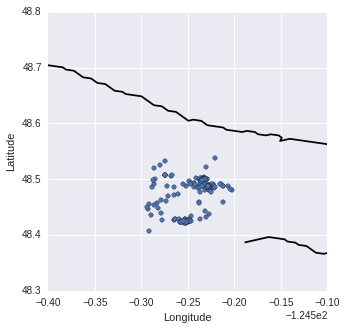

In [10]:
fig,axm = plt.subplots(1,figsize=(5,5))
data_JDF.plot(x='Longitude',y='Latitude',kind='scatter', marker='o',ax=axm)
viz_tools.plot_coastline(axm,f,coords='map')
axm.set_xlim([min_lon-.1,max_lon+.1])
axm.set_ylim([min_lat-.1,max_lat+.1])

####Observations - distribution by year and month

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3896c71390>]], dtype=object)

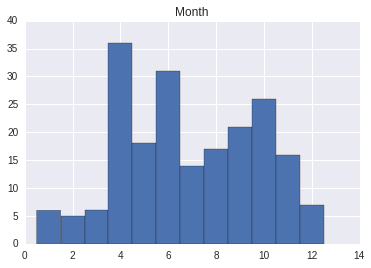

In [11]:
data_JDF.hist('Month',bins=np.arange(0.5,13.5))

Max year 2014
Min year 1976


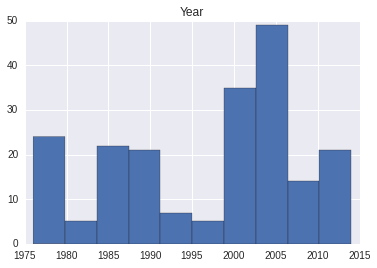

In [12]:
data_JDF.hist('Year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
print 'Max year',data_JDF['Year'].max()
print 'Min year',data_JDF['Year'].min()

#Load Model Boundary Conditions

In [13]:
bc = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_DC.nc')
lat = bc.variables['nav_lat'][:]
lon = bc.variables['nav_lon'][:]
sal = bc.variables['vosaline'][:]
depth = bc.variables['deptht'][:]
nc_tools.show_variables(bc)

[u'deptht', u'nav_lat', u'nav_lon', u'nbidta', u'nbjdta', u'nbrdta', u'time_counter', u'vosaline', u'votemper']


Isolate model BCs in same region and depths as observations 


In [14]:
#Grab only data in the lat/lon area and with bathy in depth range.

inds = np.where(np.logical_and(
            np.logical_and(X > min_lon, X< max_lon),
            np.logical_and(Y > min_lat, Y< max_lat)))
bathy_region = bathy[inds]
X_region = X[inds]
Y_region = Y[inds]
inds_depths = np.where(np.logical_and(bathy_region>=150, bathy_region <=300))
X_depths=X_region[inds_depths]
Y_depths=Y_region[inds_depths]

inds =[]
for x,y in zip(X_depths, Y_depths):
    i = np.where(np.logical_and(lon==x, lat==y))
    if i[1]:
        inds.append(i[1][0])


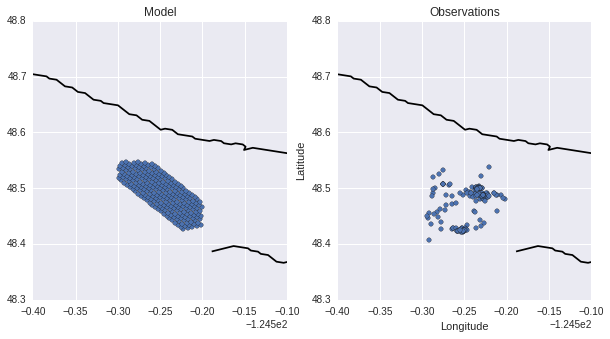

In [15]:
fig,axms = plt.subplots(1,2,figsize=(10,5))
axm=axms[0]
axm.scatter(lon[0][inds],lat[0][inds])
viz_tools.plot_coastline(axm,f,coords='map')
axm.set_xlim([min_lon-.1,max_lon+.1])
axm.set_ylim([min_lat-.1,max_lat+.1])
axm.set_title('Model')
axm=axms[1]
data_JDF.plot(x='Longitude',y='Latitude',kind='scatter', marker='o',ax=axm)
viz_tools.plot_coastline(axm,f,coords='map')
axm.set_xlim([min_lon-.1,max_lon+.1])
axm.set_ylim([min_lat-.1,max_lat+.1])
axm.set_title('Observations')

Will average in these regions over depths 150m-300m, month by month.

#Model comparisons

Plan: 

* Plot monthy mean salinity between 150 m and 300 m for both observations and model BCs.

In [16]:
def compare_average_salinity_depth(month, dmin, dmax, indices, data_obs, bcs):
    """Compares the average salinity in a depth range for observations and boundary conditions in a month
    month is the month for comaprison
    dmin, dmax define the depth range (metres)
    indices is a list of model indicest
    data_obs are the observations (DataFrame)
    bcs are the model bcs (netcdf)
    
    returns data frame means with columns:
            mean_obs array of mean salinity in each observation cast
            mean_bcs mean model salinity in at each index 
    
    """
    #initialize arrays
    mean_bcs=[]
    mean_obs =[]
    
    #Model averaging
    #Model variables 
    time = bcs.variables['time_counter']
    depth = bcs.variables['deptht']
    var = bcs.variables['vosaline'][:]
    #times convert to date time
    start = datetime.datetime(2014,1,1) #arbitrary year.
    dates = [ start + datetime.timedelta(days = 7*t) for t in time]
    #Look up model dates in the desired month
    t_inds = []; 
    for t,d in enumerate(dates):
        if d.month == month:
            t_inds.append(t)
    #depth average the model
    depth_inds = np.where(np.logical_and(depth[:]<=dmax,depth[:]>=dmin))
    dep_range = depth[depth_inds]
    for i in indices: #iterate through space index
        #Check bathymetry depth and mask id depth greater than bathy
        lat_loc=lat[0,i]; lon_loc=lon[0,i]
        inds_loc = np.where(np.logical_and(X==lon_loc, Y==lat_loc))
        masked_dep_range = np.ma.masked_greater(dep_range,bathy[inds_loc])
        for t in t_inds: #iterate through time index
            sal_in_drange = np.ma.array(var[t,depth_inds,0,i], mask=masked_dep_range.mask)
            avg_sal =  analyze.depth_average(sal_in_drange,dep_range,depth_axis=1)
            mean_bcs.append(avg_sal[0])
      
    #observation averaging
    data_m = data_obs[data_obs['Month']==month]
    for dep, var_obs in zip(data_m['Depth'],data_m['Salinity']):
        dep=np.array(dep)
        var_obs = np.array(var_obs)
        depth_inds = np.where(np.logical_and(dep[:]<=dmax,dep[:]>=dmin))
        dep_range = dep[depth_inds]
        sal_in_drange = var_obs[depth_inds]
        if (sal_in_drange !=0).any():
            avg_sal =  analyze.depth_average(sal_in_drange,dep_range,depth_axis=0)
            mean_obs.append(avg_sal)
    
    #add to dict frame
    means={'mean_bcs': mean_bcs, 'mean_obs': mean_obs}
    return means

Summary of depth averaged salinities between 150 and 300 m


/home/nsoontie/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


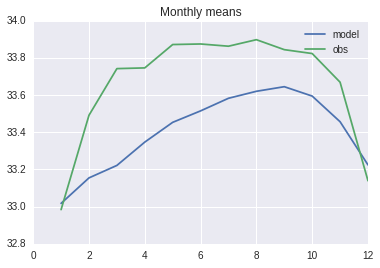

In [17]:

monthly_means={'obs':[], 'bcs':[]}
print 'Summary of depth averaged salinities between {} and {} m'.format(dmin,dmax)
grouped=data_JDF.groupby('Month')
for m in grouped.groups.keys():
    means = compare_average_salinity_depth(m,dmin,dmax,inds,data_JDF,bc)
    monthly_means['obs'].append(np.nanmean(means['mean_obs']))
    monthly_means['bcs'].append(np.nanmean(means['mean_bcs']))

#monthly means 
months = grouped.groups.keys()
fig,ax=plt.subplots(1,1)
ax.plot(months, monthly_means['bcs'],label='model')
ax.plot(months, monthly_means['obs'],label='obs')
ax.legend()
ax.set_title('Monthly means')

Notes:

* The observations do not always span the full depth range of interest. I have also tried to exclude model depths that are greater than the actual bathymetry. 
* Typically, the observation depth bins are 150, 175, 200, 225, 250
* The model depth bins are 173, 199, 226, 253, 279.
* I do not average the model for depths lower than the bathymetry

Summary of differences
Mean difference 0.259417026728
Max difference 0.520413842643
Min difference -0.085158047417


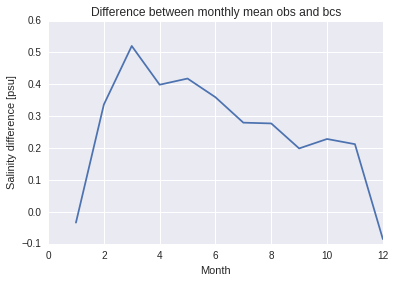

In [18]:
fig,ax=plt.subplots(1,1)
diff = np.array(monthly_means['obs'])- np.array(monthly_means['bcs'])
ax.plot(months, diff)
ax.set_title('Difference between monthly mean obs and bcs')
ax.set_ylabel('Salinity difference [psu]')
ax.set_xlabel('Month')
print 'Summary of differences'
print 'Mean difference', diff.mean()
print 'Max difference', diff.max()
print 'Min difference', diff.min()

#Summary

* In this analysis, our deep (150m-300m) SJdF water is average 0.259 psu fresher than the observations.
* The observations span 1976-2014.
* There are fewer casts in the winter months (<=6 in Jan-March)
* A seasonal trend of high salinity in the summer months and low salinity in the winter months is present in both the observations and boundary conditions. But, the deep salinity in the boundary condition is generally too low. 
* This analysis is more comprehensive than the previous analysis. I have tried to exclude averaging the model at depths that fall below the bathymetry.
* Could use this to modify BCs month by month